# Income dataset

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

income = pd.read_excel("nomis_earning_jobs_data.xlsx")

income = income.drop(index=range(0, 7)).reset_index(drop=True)
income.columns = income.iloc[0]
income = income.drop(index=0).reset_index(drop=True)
columns = list(income.columns)
for i, col in enumerate(columns):
    if pd.isna(col):
        columns[i] = 'constituency_code'
        break
income.columns = columns
columns_to_keep = [
    'parliamentary constituency 2010',
    'constituency_code',
    'Number of jobs',
    'Median',
    '10 percentile',
    '20 percentile',
    '30 percentile',
    '40 percentile',
    '60 percentile',
    '70 percentile',
    '80 percentile',
    '90 percentile'
]
income = income[columns_to_keep]
income = income.rename(columns={'Median': '50 percentile'})
income = income.drop(index=0).reset_index(drop=True)
income = income[~income.constituency_code.isna()]
column_order = [
    'parliamentary constituency 2010',
    'constituency_code',
    'Number of jobs',
    '10 percentile',
    '20 percentile',
    '30 percentile',
    '40 percentile',
    '50 percentile',
    '60 percentile',
    '70 percentile',
    '80 percentile',
    '90 percentile'
]
income = income[column_order]
income = income.replace('#', np.nan)

# Find all-na rows and copy the distribution from the closest constituency by total income

total_income = pd.read_csv("../constituencies/targets/total_income.csv")
missing_constituencies = []
for i, row in income.iterrows():
    if not pd.Series(row[3:12]).isna().all():
        continue
    
    if row.constituency_code not in total_income.code.values:
        continue

    missing_constituencies.append(row.constituency_code)

for code in missing_constituencies:
    total_income_row = total_income[total_income.code == code].iloc[0]
    ti = total_income_row.total_income_amount

    # Find the closest constituency for total income amount
    search_space = total_income[~total_income.code.isin(missing_constituencies)][total_income.code.isin(income.constituency_code)]
    difference = (search_space.total_income_amount - ti).abs()
    const_closest = search_space.iloc[difference.argmin()].code

    # Copy the distribution

    index_of_src = income[income.constituency_code == const_closest].index[0]
    index_of_tgt = income[income.constituency_code == code].index[0]

    income.iloc[index_of_tgt,3:12] = income.iloc[index_of_src,3:12]

# reference values from here: https://www.gov.uk/government/statistics/percentile-points-from-1-to-99-for-total-income-before-and-after-tax#:~:text=Details,in%20the%20Background%20Quality%20Report.
reference_values = {
    10: 15300,
    20: 18000,
    30: 20800,
    40: 23700,
    50: 27200,
    60: 31600,
    70: 37500,
    80: 46100,
    90: 62000,
    91: 65300,
    92: 69200,
    93: 74000,
    94: 79800,
    95: 87400,
    96: 97200,
    97: 111000,
    98: 137000,
    100: 199000
}

# List of columns to work on, now including 91-98 percentiles, in order
percentile_columns = [
    '10 percentile', '20 percentile', '30 percentile', '40 percentile',
    '50 percentile', '60 percentile', '70 percentile', '80 percentile',
    '90 percentile', '91 percentile', '92 percentile', '93 percentile',
    '94 percentile', '95 percentile', '96 percentile', '97 percentile',
    '98 percentile', '100 percentile'
]

# Ensure all new percentile columns exist in the DataFrame, set them to NaN initially if they don’t
for col in percentile_columns:
    if col not in income.columns:
        income[col] = np.nan

# Convert all percentile columns to numeric, coercing errors to NaN
income[percentile_columns] = income[percentile_columns].apply(pd.to_numeric, errors='coerce')

# Function to fill missing values based on reference ratios
def fill_missing_percentiles(row):
    # Extract known values and their corresponding percentiles
    known_values = {int(col.split()[0]): row[col] for col in percentile_columns if pd.notna(row[col])}

    # If no values are known, return the row unchanged
    if not known_values:
        return row

    # Sort known values by percentile to calculate intermediate values
    known_percentiles = sorted(known_values.keys())

    # Fill missing values based on ratios
    for col in percentile_columns:
        percentile = int(col.split()[0])

        # If this percentile is missing in the row
        if pd.isna(row[col]):
            # Find the closest lower and upper known percentiles
            lower = max([p for p in known_percentiles if p < percentile], default=None)
            upper = min([p for p in known_percentiles if p > percentile], default=None)

            # If both lower and upper bounds exist, interpolate
            if lower is not None and upper is not None:
                # Ratio between the target percentile and the lower bound
                lower_ratio = reference_values[percentile] / reference_values[lower]
                row[col] = row[f'{lower} percentile'] * lower_ratio

            # If only the lower bound exists, extrapolate upwards
            elif lower is not None:
                lower_ratio = reference_values[percentile] / reference_values[lower]
                row[col] = row[f'{lower} percentile'] * lower_ratio

            # If only the upper bound exists, extrapolate downwards
            elif upper is not None:
                upper_ratio = reference_values[percentile] / reference_values[upper]
                row[col] = row[f'{upper} percentile'] * upper_ratio

    return row

# Apply the function to each row in the DataFrame
income = income.apply(fill_missing_percentiles, axis=1)

# Reorder columns with the percentiles at the end
non_percentile_columns = [col for col in income.columns if col not in percentile_columns]
income = income[non_percentile_columns + percentile_columns]

# Define the columns to check for at least one non-missing value
percentile_columns = [
    '10 percentile', '20 percentile', '30 percentile', '40 percentile',
    '50 percentile', '60 percentile', '70 percentile', '80 percentile', '90 percentile'
]
# Filter rows where '100 percentile' is NaN and at least one of the specified columns is not NaN
filtered_rows = income[income['100 percentile'].isna() & income[percentile_columns].notna().any(axis=1)]
filtered_rows.head()

# Set up the '0 percentile' column in the DataFrame
income['0 percentile'] = 0

# Ensure all percentile columns are numeric, converting any non-numeric values to NaN
percentile_columns = [
    '0 percentile', '10 percentile', '20 percentile', '30 percentile', '40 percentile',
    '50 percentile', '60 percentile', '70 percentile', '80 percentile', '90 percentile',
    '91 percentile', '92 percentile', '93 percentile', '94 percentile',
    '95 percentile', '96 percentile', '97 percentile', '98 percentile', '100 percentile'
]

for col in percentile_columns:
    income[col] = pd.to_numeric(income[col], errors='coerce')

# Define the updated income bands with infinity for the last band
income_bands = [
    (0, 12570),
    (12570, 15000),
    (15000, 20000),
    (20000, 30000),
    (30000, 40000),
    (40000, 50000),
    (50000, 70000),
    (70000, 100000),
    (100000, 150000),
    (150000, 200000),
    (200000, 300000),
    (300000, 500000),
    (500000, float('inf'))  # Use infinity for the last band
]

# Function to calculate population count for each income band
def calculate_band_population(row):
    # Define the percentiles and income values, including new percentiles 91 to 98
    percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100]
    income_values = [
        row['0 percentile'], row['10 percentile'], row['20 percentile'], row['30 percentile'],
        row['40 percentile'], row['50 percentile'], row['60 percentile'], row['70 percentile'],
        row['80 percentile'], row['90 percentile'], row['91 percentile'], row['92 percentile'],
        row['93 percentile'], row['94 percentile'], row['95 percentile'], row['96 percentile'],
        row['97 percentile'], row['98 percentile'], row['100 percentile']
    ]

    # Filter out NaN values and corresponding percentiles
    filtered_percentiles = [p for p, v in zip(percentiles, income_values) if pd.notna(v)]
    filtered_income_values = [v for v in income_values if pd.notna(v)]

    # If there are insufficient data points to create a spline, return zero population counts
    if len(filtered_percentiles) < 2:
        band_df = pd.DataFrame(income_bands, columns=['income_lower_bound', 'income_upper_bound'])
        band_df['population_count'] = [0] * len(income_bands)
        band_df['parliamentary constituency 2010'] = row['parliamentary constituency 2010']
        band_df['constituency_code'] = row['constituency_code']
        return band_df

    # Fit a linear spline to the available data
    spline = interp1d(filtered_percentiles, filtered_income_values, kind='linear', fill_value="extrapolate")

    # Total jobs for this constituency (equivalent to total population)
    total_jobs = row['Number of jobs']

    # Calculate the population count for each income band
    band_population_counts = []
    for lower, upper in income_bands:
        # Find the approximate percentile range for the income band
        lower_percentile = np.interp(lower, filtered_income_values, filtered_percentiles)
        upper_percentile = np.interp(upper, filtered_income_values, filtered_percentiles)

        # Ensure lower_percentile is less than upper_percentile
        if lower_percentile < upper_percentile:
            # Integrate to get proportion in this income band
            proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
            proportion_in_band = proportion_in_band / spline(filtered_percentiles[-1])  # Normalize by max spline value
            population_in_band = proportion_in_band * total_jobs
        else:
            population_in_band = 0  # No population if band is out of range

        band_population_counts.append(population_in_band)

    # Adjust to ensure the sum matches the total jobs, if possible
    total_estimated_population = sum(band_population_counts)
    if total_estimated_population > 0:
        scaling_factor = total_jobs / total_estimated_population
        band_population_counts = [count * scaling_factor for count in band_population_counts]
    else:
        band_population_counts = [0] * len(income_bands)  # Set all to zero if no population is estimated

    # Create a result DataFrame for this row
    band_df = pd.DataFrame(income_bands, columns=['income_lower_bound', 'income_upper_bound'])
    band_df['population_count'] = band_population_counts
    band_df['parliamentary constituency 2010'] = row['parliamentary constituency 2010']
    band_df['constituency_code'] = row['constituency_code']

    return band_df

# Apply the function to each row and concatenate results
result_df = pd.concat(income.apply(calculate_band_population, axis=1).to_list(), ignore_index=True)

# Display the final DataFrame
result_df = result_df[['parliamentary constituency 2010', 'constituency_code', 'income_lower_bound', 'income_upper_bound', 'population_count']]
result_df.to_csv('../constituencies/targets/employment_income.csv', index=False)

## check:

/var/folders/r_/j9kk4vmd3tj29ljn52_76m4h0000gn/T/ipykernel_9765/1967370831.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
/var/folders/r_/j9kk4vmd3tj29ljn52_76m4h0000gn/T/ipykernel_9765/1967370831.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
/var/folders/r_/j9kk4vmd3tj29ljn52_76m4h0000gn/T/ipykernel_9765/1967370831.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
/var/folders/r_/j9kk4vmd3tj29lj

KeyboardInterrupt: 

# Dist targets

/var/folders/r_/j9kk4vmd3tj29ljn52_76m4h0000gn/T/ipykernel_5685/2054514912.py:72: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
/var/folders/r_/j9kk4vmd3tj29ljn52_76m4h0000gn/T/ipykernel_5685/2054514912.py:72: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
/var/folders/r_/j9kk4vmd3tj29ljn52_76m4h0000gn/T/ipykernel_5685/2054514912.py:72: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  proportion_in_band, _ = quad(spline, lower_percentile, upper_percentile)
/var/folders/r_/j9kk4vmd3tj29lj

## add total_earning:

In [ ]:
result_df['total_earning'] = result_df['population_count'] * (
    (np.where(result_df['income_upper_bound'] == np.inf, 1000000, result_df['income_upper_bound']) + result_df['income_lower_bound']) / 2
)

In [ ]:
result_df.head(30)

,parliamentary constituency 2010,constituency_code,income_lower_bound,income_upper_bound,population_count,total_earning
0,Berwick-upon-Tweed,E14000554,0,12570.0,326.275224,2.050640e+06
1,Berwick-upon-Tweed,E14000554,12570,15000.0,548.569959,7.562037e+06
2,Berwick-upon-Tweed,E14000554,15000,20000.0,1628.732920,2.850283e+07
3,Berwick-upon-Tweed,E14000554,20000,30000.0,3960.259294,9.900648e+07
4,Berwick-upon-Tweed,E14000554,30000,40000.0,1687.140441,5.904992e+07
5,Berwick-upon-Tweed,E14000554,40000,50000.0,2630.788915,1.183855e+08
6,Berwick-upon-Tweed,E14000554,50000,70000.0,3513.563940,2.108138e+08
7,Berwick-upon-Tweed,E14000554,70000,100000.0,2111.623615,1.794880e+08
8,Berwick-upon-Tweed,E14000554,100000,150000.0,1666.938775,2.083673e+08
9,Berwick-upon-Tweed,E14000554,150000,200000.0,1470.014003,2.572525e+08


In [ ]:
result_df.to_csv('Earnings_distribution_targets.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test

In [ ]:
second_constituency = result_df['parliamentary constituency 2010'].unique()[5]

# Filter result_df for rows with the second unique constituency
second_constituency_rows = result_df[result_df['parliamentary constituency 2010'] == second_constituency]

# Print all rows for the second unique value
second_constituency_rows.head(20)

,parliamentary constituency 2010,constituency_code,income_lower_bound,income_upper_bound,population_count,total_earning
65,Darlington,E14000658,0,12570.0,563.071112,3.538902e+06
66,Darlington,E14000658,12570,15000.0,733.508039,1.011141e+07
67,Darlington,E14000658,15000,20000.0,2162.652153,3.784641e+07
68,Darlington,E14000658,20000,30000.0,7184.469323,1.796117e+08
69,Darlington,E14000658,30000,40000.0,6245.097215,2.185784e+08
70,Darlington,E14000658,40000,50000.0,3333.435923,1.500046e+08
71,Darlington,E14000658,50000,70000.0,4202.850590,2.521710e+08
72,Darlington,E14000658,70000,100000.0,2637.520440,2.241892e+08
73,Darlington,E14000658,100000,150000.0,2293.722739,2.867153e+08
74,Darlington,E14000658,150000,200000.0,1643.672468,2.876427e+08


In [ ]:
second_constituency_rows['population_count'].sum()

31000.000000000007

In [ ]:
second_constituency = income['parliamentary constituency 2010'].unique()[5]

# Filter result_df for rows with the second unique constituency
second_constituency_rows = income[income['parliamentary constituency 2010'] == second_constituency]

# Print all rows for the second unique value
second_constituency_rows.head(20)

,parliamentary constituency 2010,constituency_code,Number of jobs,10 percentile,20 percentile,30 percentile,40 percentile,50 percentile,60 percentile,70 percentile,...,91 percentile,92 percentile,93 percentile,94 percentile,95 percentile,96 percentile,97 percentile,98 percentile,100 percentile,0 percentile
5,Darlington,E14000658,31000,13298.0,16723.0,20778.0,23407.0,27158.0,30471.0,33812.0,...,58877.962667,62394.410667,66722.346667,71951.936,78804.501333,87640.704,100083.52,123526.506667,179429.013333,0


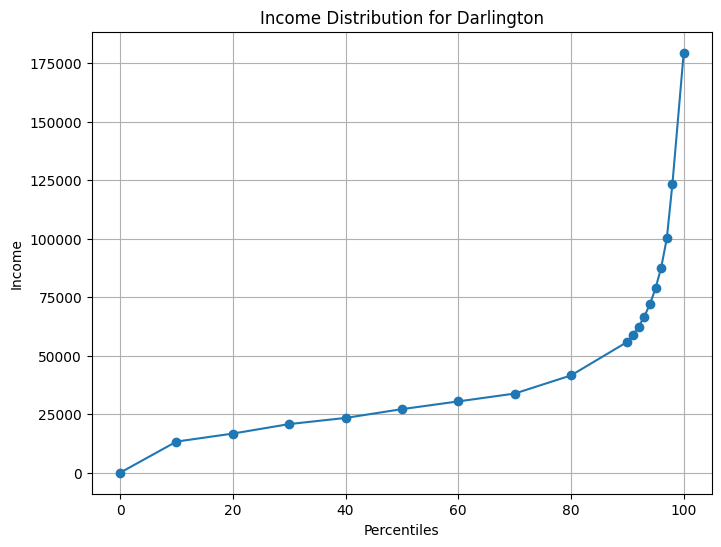

In [ ]:
second_constituency = income['parliamentary constituency 2010'].unique()[5]

# Filter matched_rows for rows corresponding to this second unique constituency
second_constituency_row = income[income['parliamentary constituency 2010'] == second_constituency].iloc[0]

# Define the percentiles and income values, including the 0th percentile and new percentiles (91 to 98)
percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100]
income_values = [
    0,  # Income for 0 percentile
    second_constituency_row['10 percentile'],
    second_constituency_row['20 percentile'],
    second_constituency_row['30 percentile'],
    second_constituency_row['40 percentile'],
    second_constituency_row['50 percentile'],
    second_constituency_row['60 percentile'],
    second_constituency_row['70 percentile'],
    second_constituency_row['80 percentile'],
    second_constituency_row['90 percentile'],
    second_constituency_row['91 percentile'],
    second_constituency_row['92 percentile'],
    second_constituency_row['93 percentile'],
    second_constituency_row['94 percentile'],
    second_constituency_row['95 percentile'],
    second_constituency_row['96 percentile'],
    second_constituency_row['97 percentile'],
    second_constituency_row['98 percentile'],
    second_constituency_row['100 percentile']
]

# Filter out NaN values
filtered_percentiles = [p for p, income in zip(percentiles, income_values) if pd.notna(income)]
filtered_income_values = [income for income in income_values if pd.notna(income)]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(filtered_percentiles, filtered_income_values, marker='o')
plt.xlabel('Percentiles')
plt.ylabel('Income')
plt.title(f'Income Distribution for {second_constituency}')
plt.grid(True)
plt.show()